# BERT көмегімен Сентимент Анализ

> Бұл оқу құралында сіз BERT моделін сентимент анализге бейімдеуді үйренесіз. Мәтінді алдын ала өңдеуден (арнайы токендер, толықтыру және назар маскалары) өткізіп, Hugging Face әзірлеген керемет Transformers кітапханасын қолданып, Сентимент Классификатор жасайсыз!

Сіз келесі нәрселерді үйренесіз:

- BERT моделінің мәнін интуитивті түсіну
- Мәтін деректерін BERT үшін алдын ала өңдеу және PyTorch Dataset дайындау (токенизация, назар маскалары және толықтыру)
- Hugging Face ұсынған Transformers кітапханасын пайдалана отырып, Transfer Learning арқылы Сентимент Классификатор құру
- Модельді тест деректері бойынша бағалау
- Шикі мәтінге сентимент болжамын жасау

**Сіздің тапсырмаңыз:**

- 12-ші аптада жиналған деректерді пайдаланыңыз
- Осы сентимент анализді орындау үшін BERT негізіндегі [KazRoberta](https://huggingface.co/kz-transformers/kaz-roberta-conversational). моделін пайдаланыңыз. Осы модельді жүктеп, берілген кодпен жұмысыңызды сынақтан өткізіңіз.

**Материалдар:**

- [Оқу құралымен танысу](https://www.curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/)
- [Google Colab арқылы ноутбукты браузерде іске қосу](https://colab.research.google.com/drive/1PHv-IRLPCtv7oTcIGbsgZHqrB5LPvB7S)
- [`Getting Things Done with PyTorch` кітабын оқу](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

In [1]:
# Алдымен colab құрылғысының T4 графикалық процессорына қосылыңыз.
!nvidia-smi

Mon Apr 21 22:29:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## BERT дегеніміз не?

BERT ([осы мақалада](https://arxiv.org/abs/1810.04805) ұсынылған) — Bidirectional Encoder Representations from Transformers дегеннің қысқартылған атауы. Егер сіз бұл терминдердің көпшілігі нені білдіретінін білмесеңіз – дұрыс жерге келдіңіз! Негізгі идеяларды тарқатайық:

- **Bidirectional (Екіжақты)** – мәтінді түсіну үшін алдыңғы сөздерге де, кейінгі сөздерге де қарау қажет.
- **Transformers (Трансформерлер)** – [“Attention Is All You Need”](https://arxiv.org/abs/1706.03762) мақаласында Трансформер моделі ұсынылған. Бұл модель бірден барлық токендер тізбегін оқи алады. Бұл тұрғыда ол біржақты емес, ал LSTM-дер тізбекті түрде (солдан оңға немесе оңнан солға қарай) оқиды. Назар аудару механизмі сөздер арасындағы контекстік байланысты үйренуге мүмкіндік береді (мысалы, сөйлемдегі `оның` сөзі Джимге қатысты болуы мүмкін).
- **(Алдын ала үйретілген) контекстік сөз ендірулері** – [ELMO мақаласы](https://arxiv.org/abs/1802.05365v2) сөздерді мағынасына/контекстіне байланысты кодтаудың жаңа тәсілін ұсынды. Мысалы, “nails” сөзі тырнақ немесе шеге деген мағына беруі мүмкін.

BERT 15% токендерді маскалап, соларды табуды үйрену арқылы жаттықты. Қосымша мақсат – келесі сөйлемді болжау болды. Осы тапсырмалардың мысалдарына тоқталайық:

### Маскаланған Тілді Модельдеу (Masked LM)

Бұл тапсырманың мақсаты – маскаланған токендерді болжау. Мысалға қарап көрейік:

That’s `[mask]` she `[mask]` → That’s what she said

### Келесі Сөйлемді Болжау (Next Sentence Prediction, NSP)

Екі сөйлем жұбы берілгенде, екіншісі біріншісінен кейін келе ме, жоқ па – соны анықтау керек (бинарлы классификация). Мысал жалғасы:

*Кіріс* = `[CLS]` That’s `[mask]` she `[mask]`. [SEP] Hahaha, nice! [SEP]  
*Белгі* = *IsNext*

*Кіріс* = `[CLS]` That’s `[mask]` she `[mask]`. [SEP] Dwight, you ignorant `[mask]`! [SEP]  
*Белгі* = *NotNext*

Жаттығу корпусында екі дереккөз қолданылды: [Toronto Book Corpus](https://arxiv.org/abs/1506.06724) (800 миллион сөз) және Ағылшын Википедиясы (2.5 миллиард сөз). Бастапқы Трансформерде кодтаушы (енгізуді оқу үшін) және декодтаушы (болжам жасау үшін) болса, BERT тек кодтаушыны пайдаланады.

BERT — бұл Трансформер кодтаушыларынан тұратын алдын ала үйретілген модель. Қанша кодтаушы? Екі нұсқасы бар – 12 (BERT Base) және 24 (BERT Large).

### Бұл модель шынайы өмірде пайдалы ма?

BERT мақаласы [ашық кодымен](https://github.com/google-research/bert) және алдын ала үйретілген модельдерімен бірге жарияланды.

Ең жақсы жағы – BERT көмегімен көптеген NLP тапсырмалар үшін Transfer Learning (OpenAI Transformer идеяларының арқасында) жасауға болады: классификация, сұраққа жауап беру, нысанды тану, т.б. Аз ғана дерекпен де жоғары нәтижеге қол жеткізуге болады!

## Орнату

Бізге [Hugging Face ұсынған Transformers кітапханасы](https://huggingface.co/transformers/) қажет болады:

In [2]:
!pip install -q -U watermark
!pip install transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.0 MB/s eta 0:00:00


In [3]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.11.12
IPython version      : 7.34.0

numpy       : 2.0.2
pandas      : 2.2.2
torch       : 2.6.0+cu124
transformers: 4.51.3



In [4]:
#@title Орнату және конфигурациялау
import transformers
from transformers import BertModel, BertTokenizer, get_linear_schedule_with_warmup
from torch.optim import AdamW
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Деректерді зерттеу

Hugging Face-тен [KazSAnDRA](https://huggingface.co/datasets/issai/kazsandra) деректер жиынтығын жүктейміз.


In [5]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which

Жүктеу алдында Hugging Face‑ке тіркеліп, KazSAnDRA‑ға қол жеткізу рұқсатын алуыңыз қажет


**Profile -> settings -> access token**

In [6]:
from huggingface_hub import login
login("сіздың токеніңіз")

Деректер жинағын жүктеп алуды бастаңыз

In [7]:
from datasets import load_dataset

dataset = load_dataset("issai/kazsandra",split="train[:5%]")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/11.5k [00:00<?, ?B/s]

full.csv:   0%|          | 0.00/24.4M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/180064 [00:00<?, ? examples/s]

In [8]:
dataset

Dataset({
    features: ['custom_id', 'text', 'label', 'domain'],
    num_rows: 9003
})

Бізде шамамен 9 мың мысал бар.

In [9]:
df = dataset.to_pandas()

Тамаша, ұпайлар мен шолу мәтіндерінде ешқандай мәндер жоқ! Бізде сыныптық теңгерімсіздік бар ма?

<ipython-input-10-d23702d9832a>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=df, palette=palette)


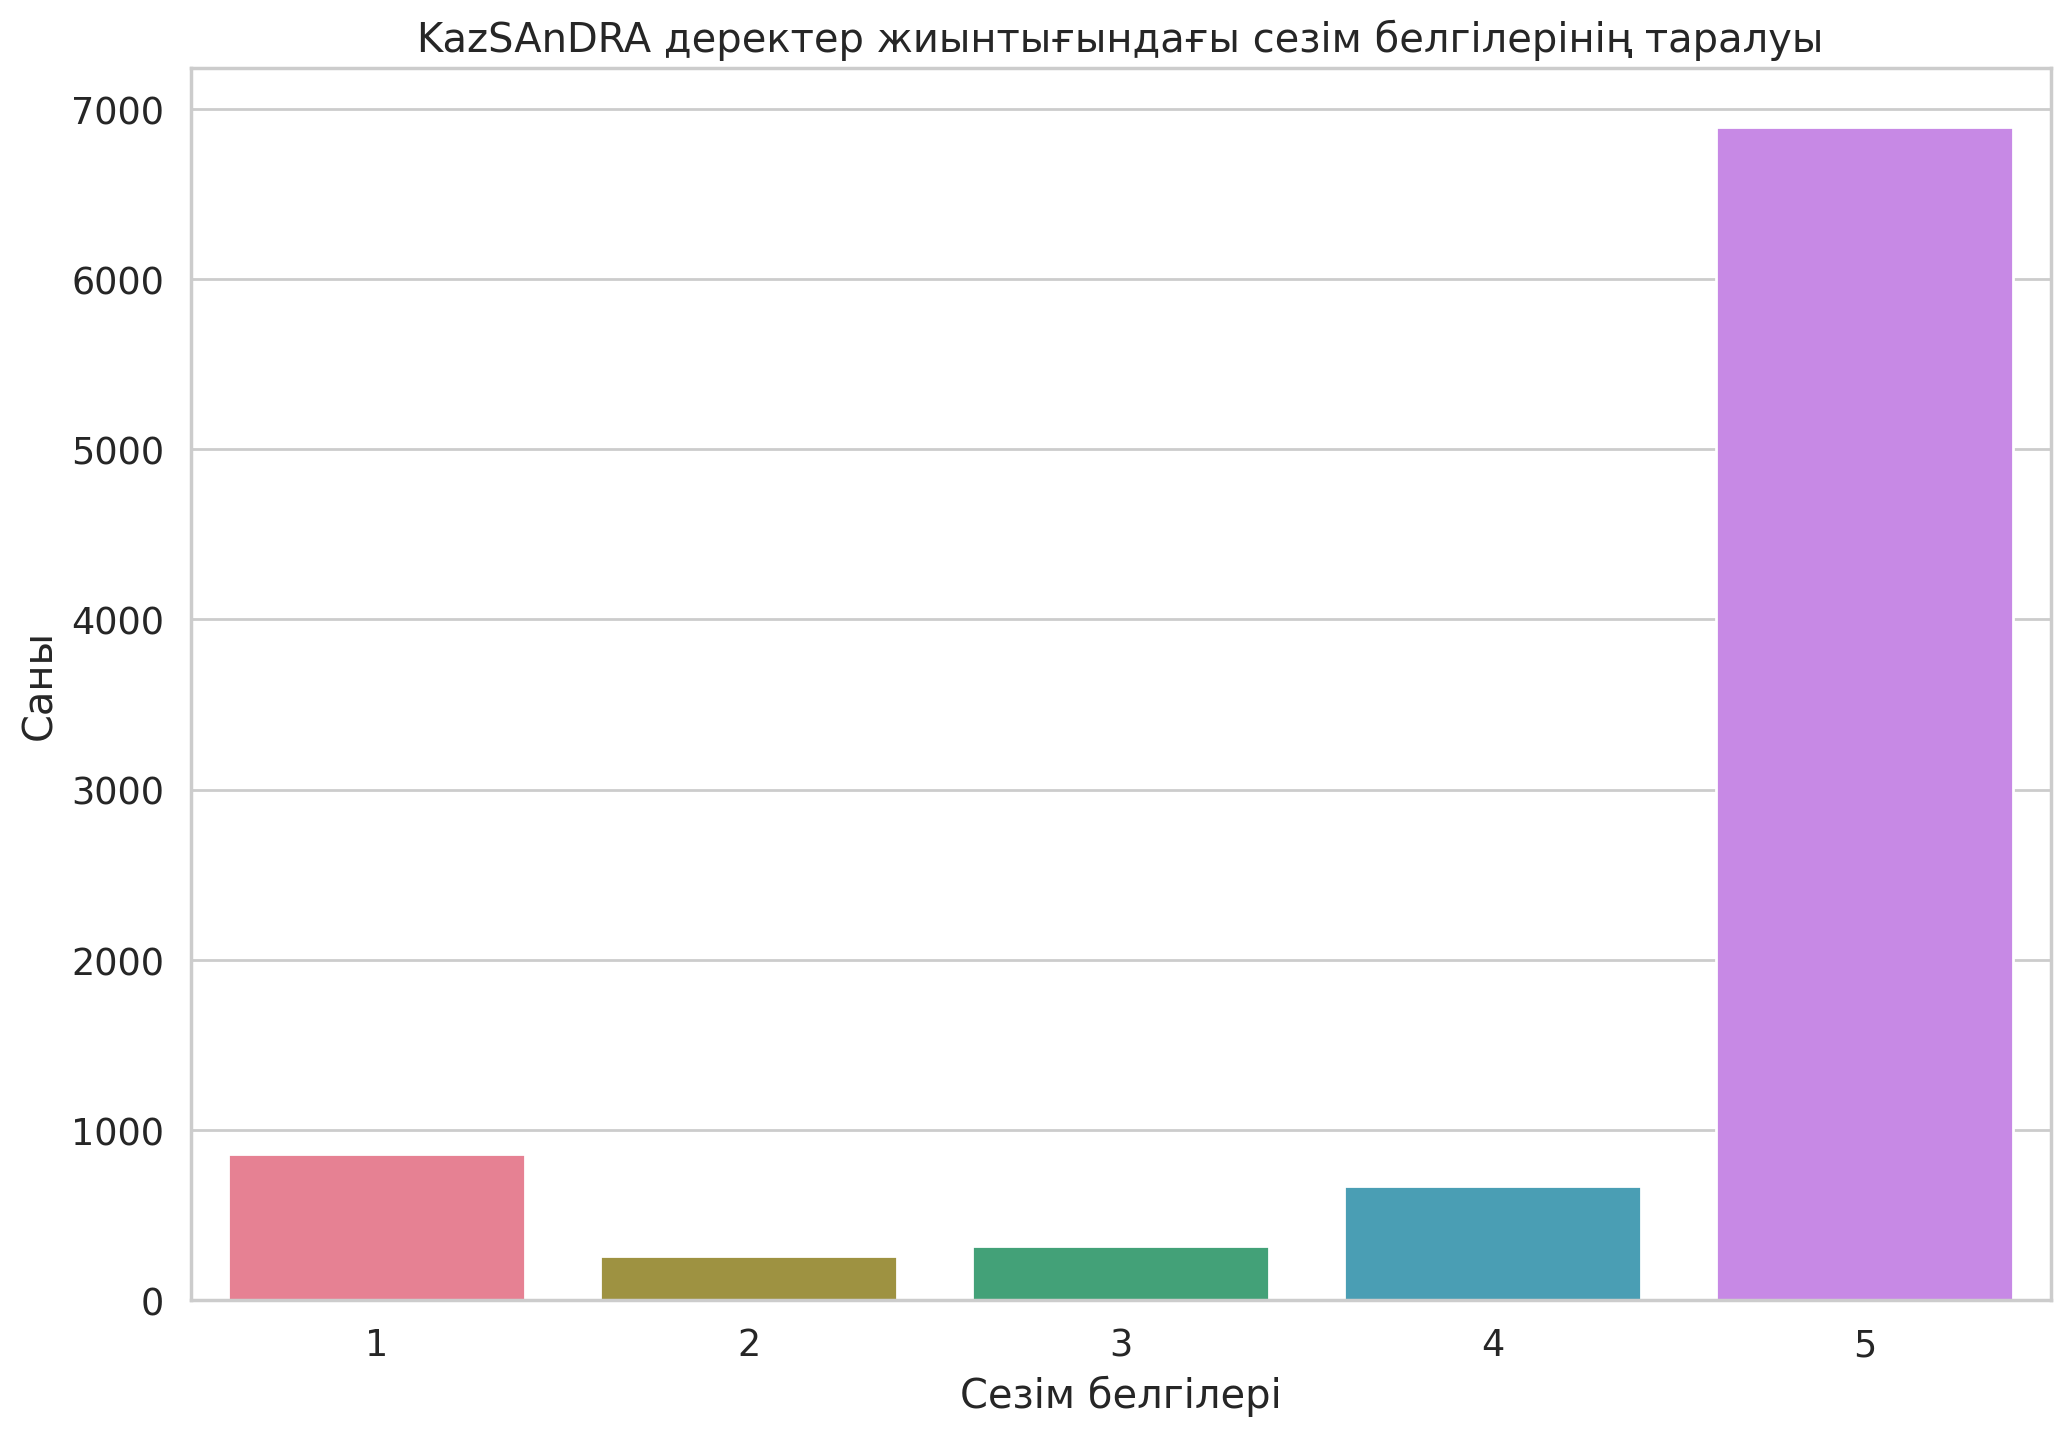

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

palette = sns.color_palette("husl", df["label"].nunique())

sns.countplot(x="label", data=df, palette=palette)

plt.xlabel("Сезім белгілері")
plt.ylabel("Саны")
plt.title("KazSAnDRA деректер жиынтығындағы сезім белгілерінің таралуы")
plt.show()

Бұл өте теңгерімсіздік, бірақ бәрібір. Біз деректер жинағын теріс, бейтарап және оң көңіл-күйге түрлендіреміз:

In [11]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else:
    return 2

df['sentiment'] = df.label.apply(to_sentiment)

In [12]:
class_names = ['negative', 'neutral', 'positive']

<ipython-input-13-519ce6604931>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='sentiment', data=df, palette=palette)
<ipython-input-13-519ce6604931>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(class_names)


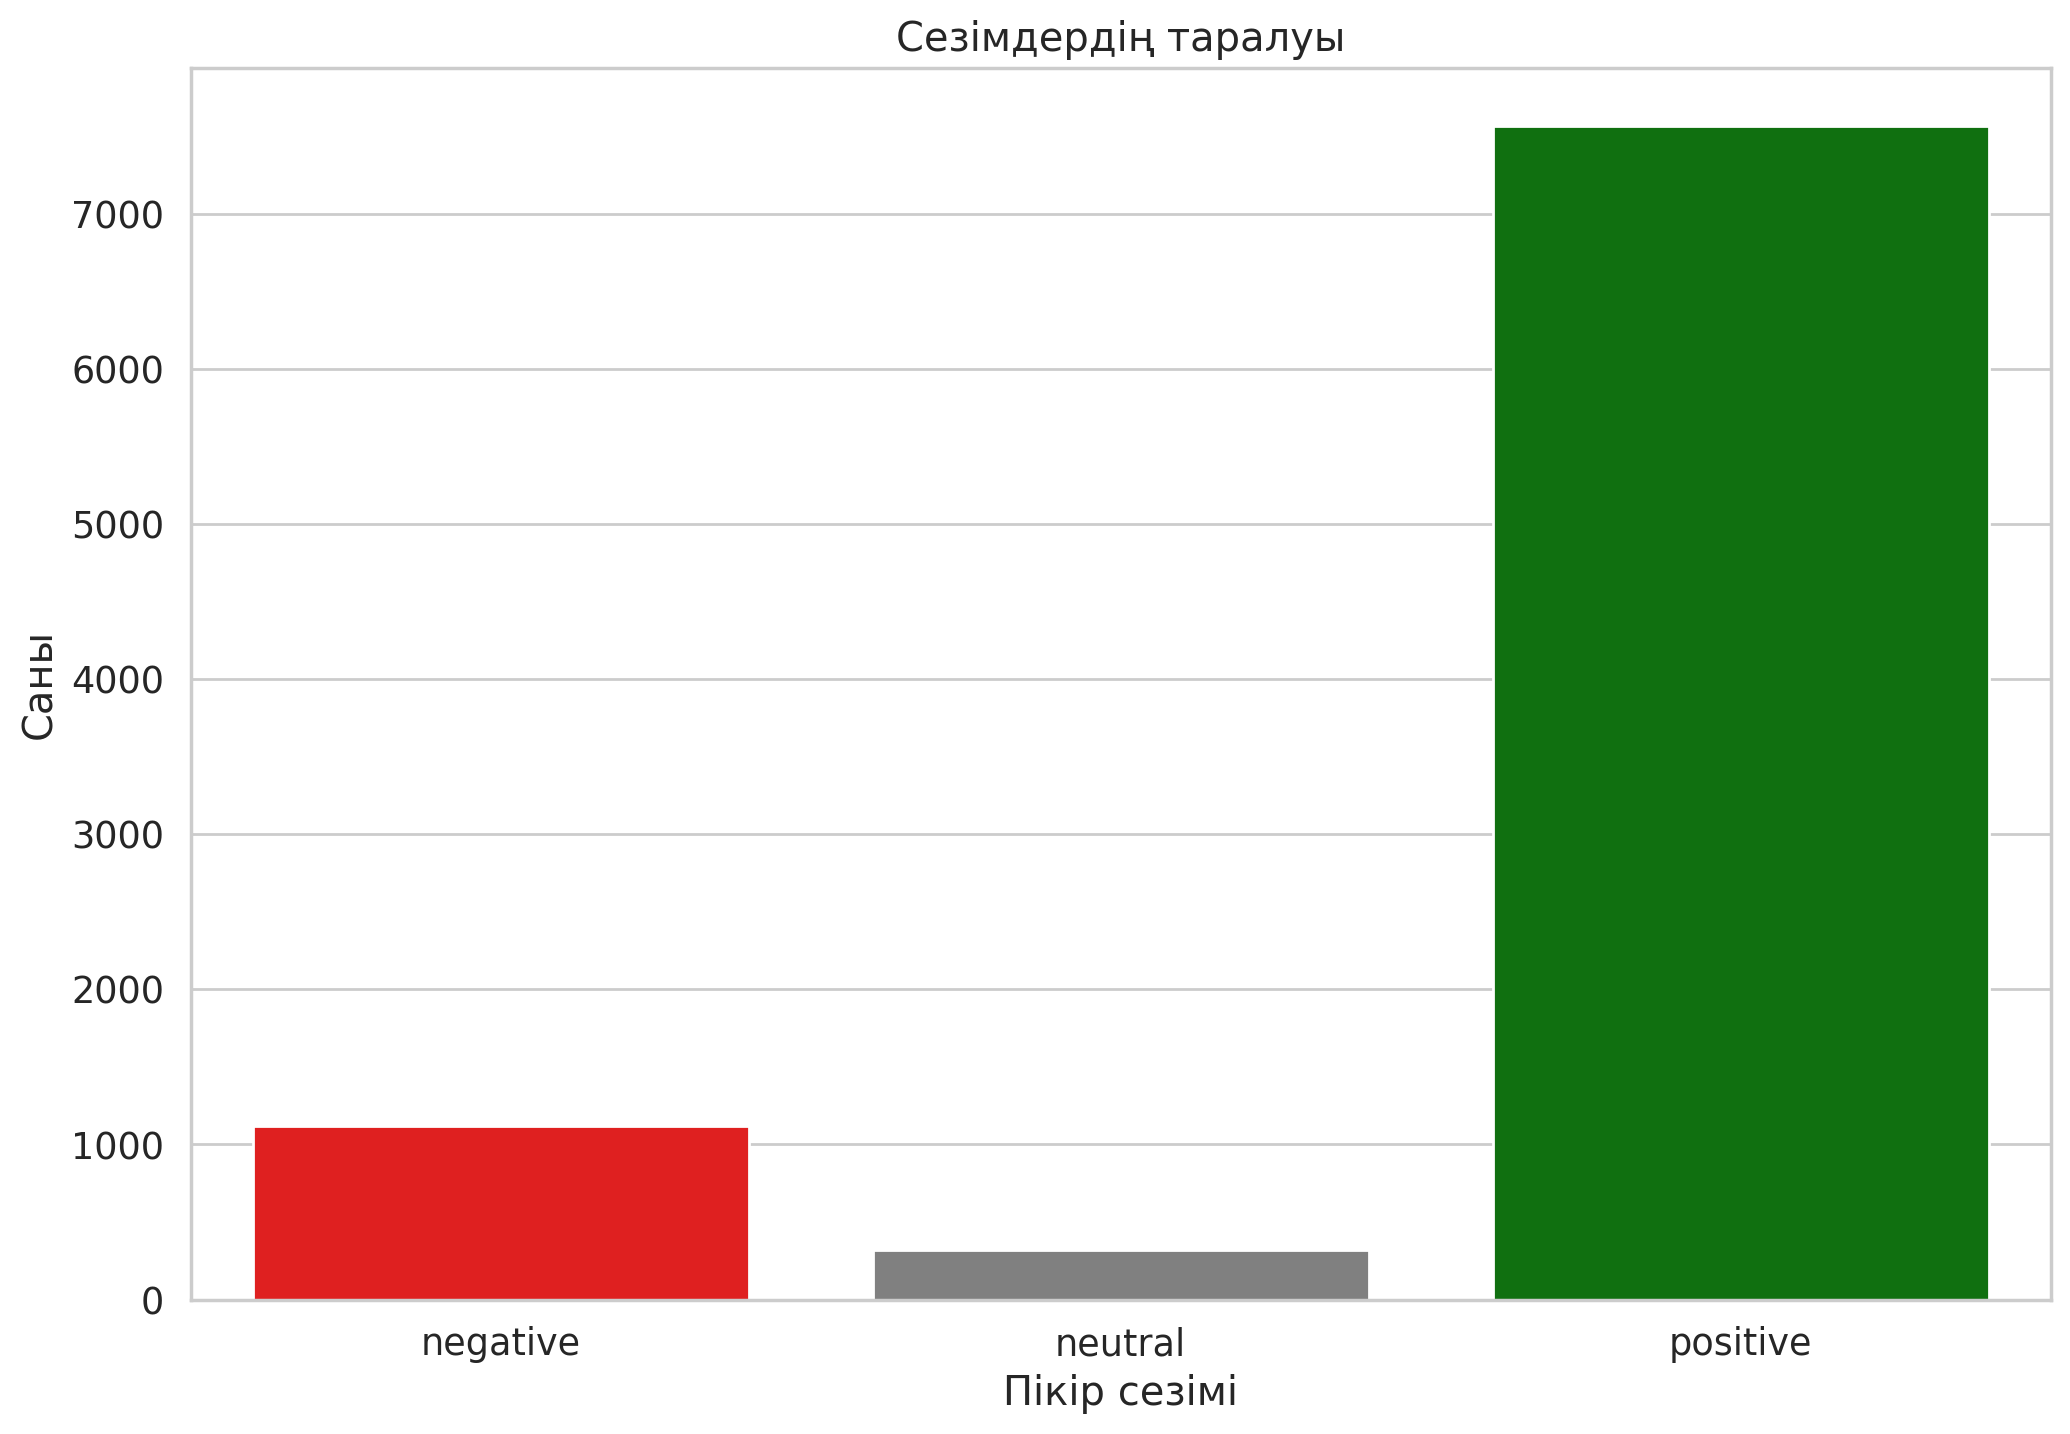

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

palette = sns.color_palette(['red', 'gray', 'green'])

ax = sns.countplot(x='sentiment', data=df, palette=palette)
plt.xlabel('Пікір сезімі')
plt.ylabel('Саны')
plt.title('Сезімдердің таралуы')

ax.set_xticklabels(class_names)
plt.show()

## Деректерді алдын ала өңдеу

Машиналық оқыту үлгілері өңделмеген мәтінмен жұмыс істей алмайтынын білетін боларсыз. Мәтінді біртекті сандарға түрлендіру қажет. Ал BERT үшін бұдан да мұқият дайындық қажет, негізгі талаптар:

- Сөйлемдерге арнайы лексемаларды қосу және оларды дұрыс түрде жіктеу  
- Біркелкі ұзындықтағы тізбектерді қалыптастыру (қысқаларын толтырғышпен толықтыру)  
- *Назар маскасы* деп аталатын массив жасау — онда 0 мәндері толтырғыш токендерді, ал 1 мәндері нақты токендерді көрсетеді  

Transformers кітапханасы — BERT секілді көптеген Transformer үлгілерін ұсынады. Ол TensorFlow және PyTorch-пен жұмыс істей алады! Сонымен қатар, біз үшін жұмысты атқаратын алдын ала дайындалған токенизаторлар да бар!

In [14]:
PRE_TRAINED_MODEL_NAME = 'kz-transformers/kaz-roberta-conversational'

Алдын ала үйретілген токенизаторын жүктейік:

In [15]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

config.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.69M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.33M [00:00<?, ?B/s]

Токенизация процесін түсіну үшін осы мәтінді қолданамыз:

In [16]:
sample_txt = 'Бұл өте жақсы өнім'

Кейбір негізгі операциялар мәтінді таңбалауыштарға және таңбалауыштарды бірегей бүтін сандарға (идентификаторларға) түрлендіре алады:

In [17]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'   Сөйлем: {sample_txt}')
print(f' Токендер: {tokens}')
print(f'Токен IDs: {token_ids}')

   Сөйлем: Бұл өте жақсы өнім
 Токендер: ['ÐĳÒ±Ð»', 'ĠÓ©ÑĤÐµ', 'ĠÐ¶Ð°ÒĽÑģÑĭ', 'ĠÓ©Ð½ÑĸÐ¼']
Токен IDs: [1962, 1555, 1867, 2542]


In [18]:
tokenizer.decode([1962, 1555, 1867, 2542])

'Бұл өте жақсы өнім'

### Арнайы белгілер

`[SEP]` - сөйлемнің аяқталуына арналған маркер

In [19]:
tokenizer.sep_token, tokenizer.sep_token_id

('</s>', 2)

`[CLS]` - біз бұл таңбалауышты әрбір сөйлемнің басына қосуымыз керек, сондықтан BERT классификация жасап жатқанымызды біледі

In [20]:
tokenizer.cls_token, tokenizer.cls_token_id

('<s>', 0)

Сондай-ақ толтыруға (padding) арналған арнайы белгі бар:

In [21]:
tokenizer.pad_token, tokenizer.pad_token_id

('<pad>', 1)

BERT жаттығу жиынында болған таңбалауыштарды түсінеді. Қалғанының барлығын `[UNK]` (белгісіз) таңбалауышы арқылы кодтауға болады:

In [22]:
tokenizer.unk_token, tokenizer.unk_token_id

('<unk>', 3)

Бұл жұмыстардың барлығын [`encode_plus()`](https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.encode_plus) әдісі арқылы орындауға болады:

In [23]:
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length=32,
    add_special_tokens=True,  # '[CLS]' және '[SEP]' қосу
    return_token_type_ids=False,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt',      # PyTorch тензорларын қайтару
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

Токен идентификаторлары енді тензорда сақталады және 32 ұзындыққа толтырылады:

In [24]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([   0, 1962, 1555, 1867, 2542,    2,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1])

Назар аударатын масканың ұзындығы бірдей:

In [25]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

Арнайы белгілерді көру үшін токенизацияны кері айналдыра аламыз:

In [26]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['<s>',
 'ÐĳÒ±Ð»',
 'ĠÓ©ÑĤÐµ',
 'ĠÐ¶Ð°ÒĽÑģÑĭ',
 'ĠÓ©Ð½ÑĸÐ¼',
 '</s>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>']

### Тізбек ұзындығын таңдау

BERT тұрақты ұзындықтағы тізбектермен жұмыс істейді. Біз максималды ұзындықты таңдау үшін қарапайым стратегияны қолданамыз. Әрбір шолудың таңбалауыш ұзындығын сақтайық:

In [27]:
token_lens = []

for txt in df.text:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

және үлестіруді сызыңыз:

<ipython-input-28-670dc1442096>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


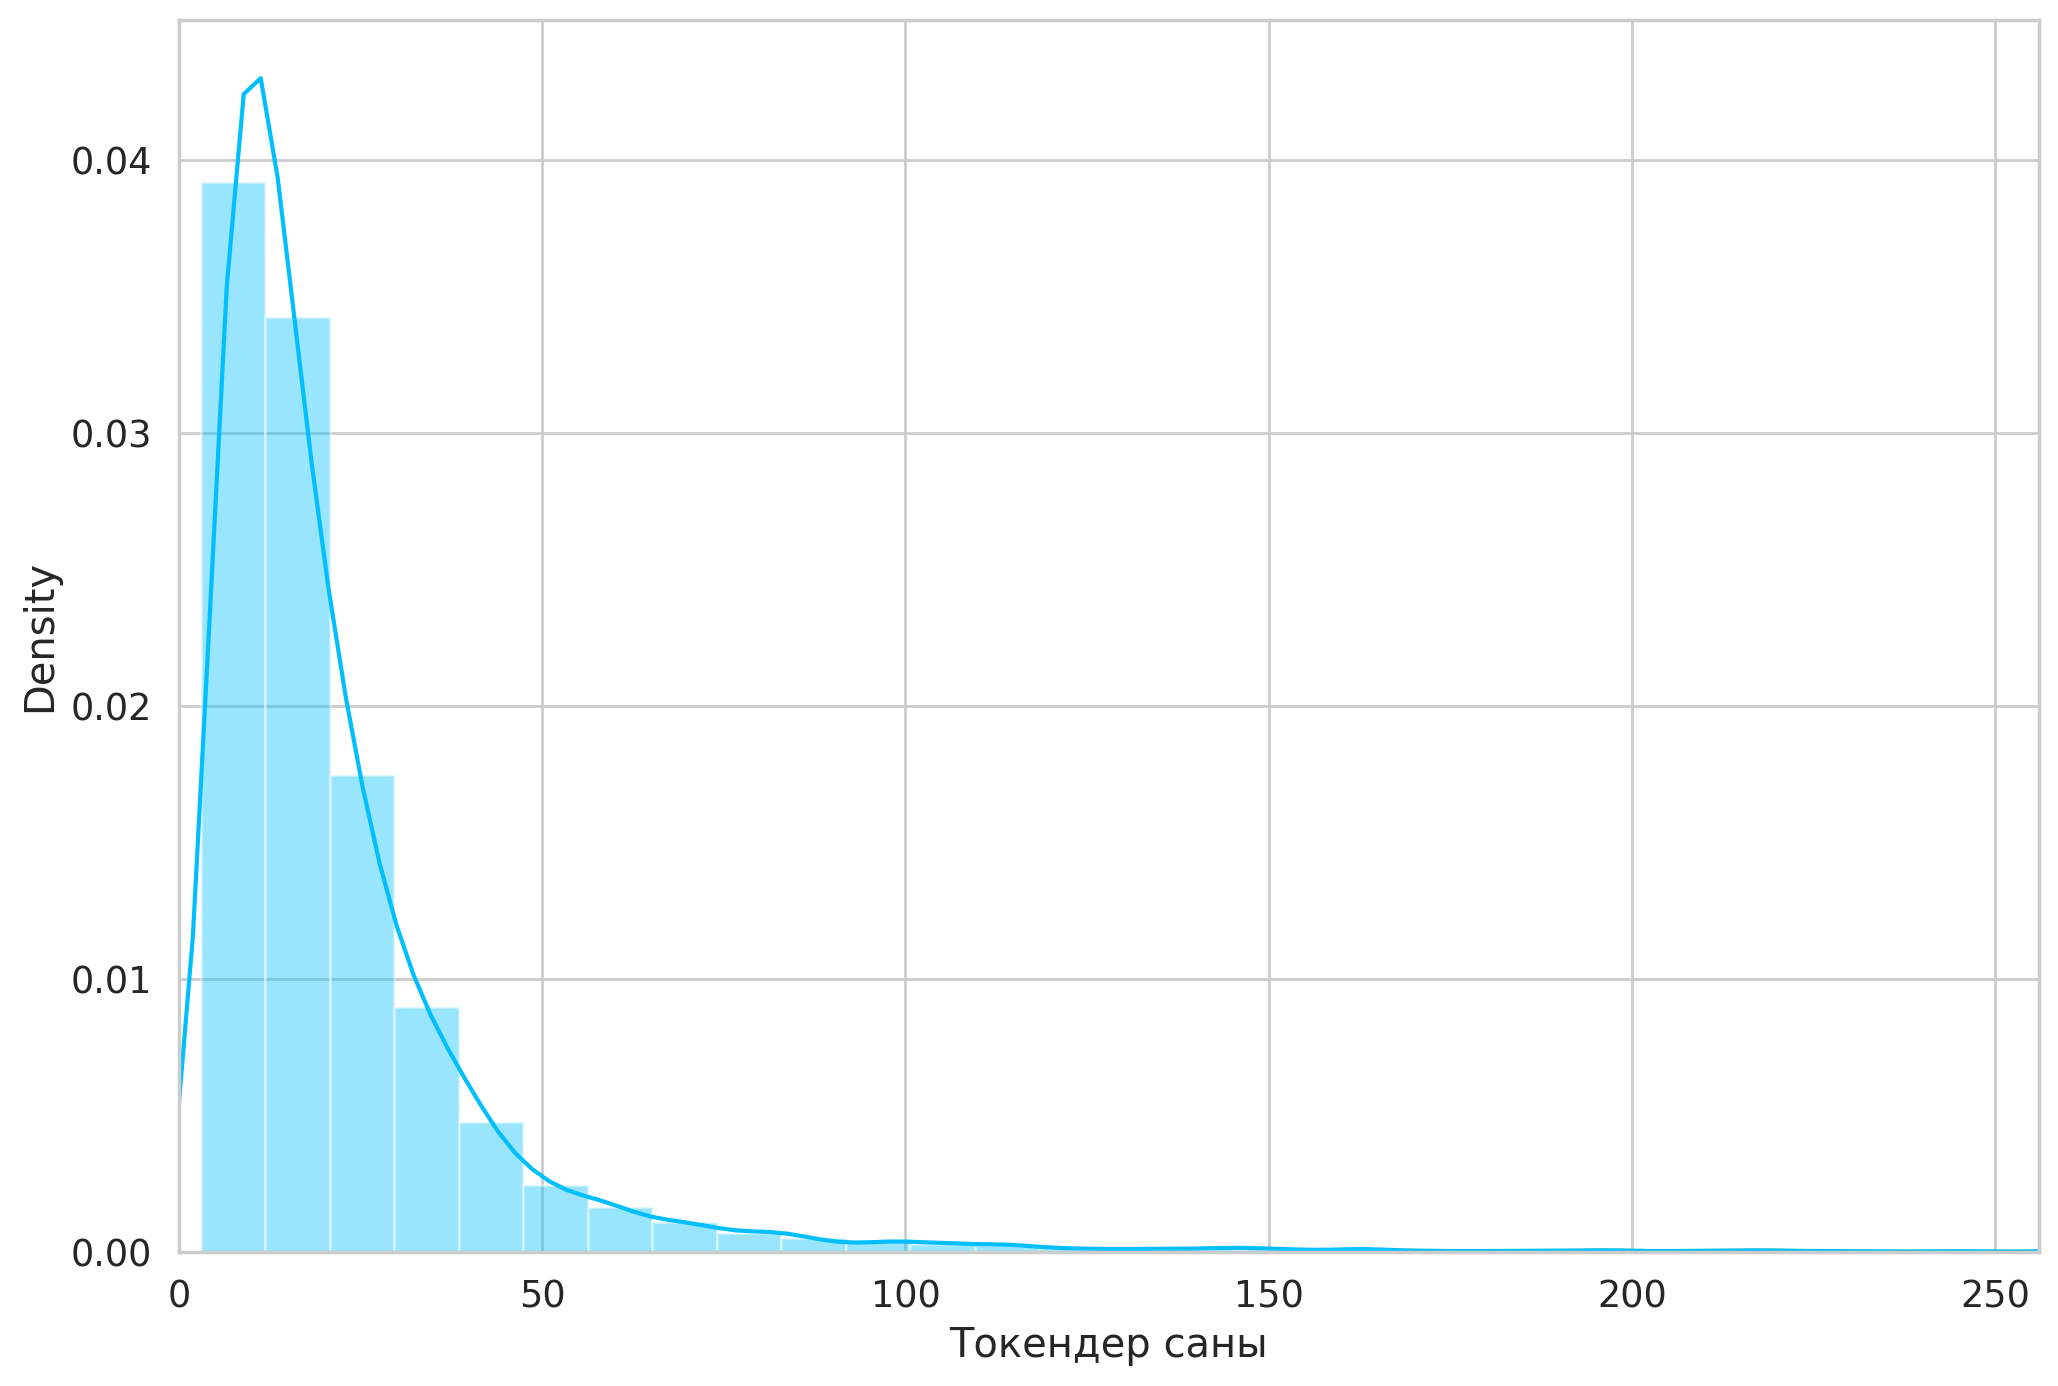

In [28]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Токендер саны');

Көптеген шолуларда 100 токеннен аз сөз болғанымен, қауіпсіз болу үшін максималды ұзындығын 128 токен деп белгілейміз.

In [29]:
MAX_LEN = 128

PyTorch деректер жиынтығын құру үшін барлық қажетті элементтер бар. Ендеше, іске асырайық:

In [30]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

Токенизатор біз үшін ауыр жүктің көп бөлігін жасайды. Біз сондай-ақ шолу мәтіндерін қайтарамыз, сондықтан біздің үлгідегі болжамдарды бағалау оңайырақ болады. Деректерді бөлейік:

In [31]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [32]:
df_train.shape, df_val.shape, df_test.shape

((8102, 5), (450, 5), (451, 5))

Біз сондай-ақ бірнеше деректерді жүктеуші жасауымыз керек. Міне, мұны істеу үшін көмекші функция:

In [33]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.text.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [34]:
BATCH_SIZE = 32

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Жаттығу деректерін жүктеушіден мысал пакетін (batch) қарастырайық:

In [35]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [36]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])


## Kazroberta және Huggingfaceпен сезім классификациясы

In [37]:
from transformers import RobertaModel, RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained("kz-transformers/kaz-roberta-conversational")
model     = RobertaModel.from_pretrained("kz-transformers/kaz-roberta-conversational")

model.safetensors:   0%|          | 0.00/334M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at kz-transformers/kaz-roberta-conversational and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Transformers кітапханасымен BERT пайдалануды жеңілдететін көптеген көмекшілер бар. Тапсырмаға байланысты [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification), [BertForQuestionAnswering](https://huggingface.co/transformers/model_doc/bertqueing.html) немесе бір нәрсе пайдаланғыңыз келуі мүмкін.

Үлгіні жүктеп алайық:

In [38]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "kz-transformers/kaz-roberta-conversational",
    num_labels=3,           # or whatever your downstream task has
    return_dict=True        # ensure outputs are returned as a dataclass
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at kz-transformers/kaz-roberta-conversational and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Оны біздің үлгі мәтінді кодтауда қолдануға тырысыңыз:

`last_hidden_state` модельдің соңғы қабатының жасырын күйлерінің тізбегі болып табылады. `pooled_output` алу үшін [BertPooler] `last_hidden_state`-қа қолданылуы қажет:

In [39]:
from transformers import AutoTokenizer, AutoModel

text = "бүгін ауа райы жақсы"

model     = RobertaModel.from_pretrained("kz-transformers/kaz-roberta-conversational")

inputs  = tokenizer(text, return_tensors="pt")
outputs = model(**inputs)

last_hidden_state = outputs.last_hidden_state   # [batch, seq_len, hidden_size]
pooled_output     = outputs.pooler_output       # [batch, hidden_size]

print(last_hidden_state.shape)
print(pooled_output.shape)

Some weights of RobertaModel were not initialized from the model checkpoint at kz-transformers/kaz-roberta-conversational and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([1, 6, 768])
torch.Size([1, 768])



> `last_hidden_state` tensorрының `[1, 6, 768]` пішіні бар, яғни бізде кірістегі 8 таңбалауыштың әрқайсысы үшін 768 өлшемді жасырын вектор бар. Содан кейін "біріктірілген_шығару" оны "[1, 768]" етіп қысқартады, бүкіл реттілік үшін жалғыз 768 өлшемді жиынтық береді. Модель конфигурациясында 768 "жасырын_өлшем" екенін растай аласыз.

In [40]:
model.config.hidden_size

768

BERT пікірінше, «біріктірілген_шығыс» мазмұнының қысқаша мазмұны ретінде қарастыруға болады. Дегенмен, сіз тырысып, жақсырақ жасай аласыз. Шығарылымның пішінін қарастырайық:

In [41]:
pooled_output.shape

torch.Size([1, 768])

Біз осы білімнің барлығын Rembert үлгісін қолданатын классификатор құру үшін пайдалана аламыз:

In [42]:
from torch import nn
from transformers import RobertaModel, AutoTokenizer

class SentimentClassifier(nn.Module):
    def __init__(self, n_classes=3):
        super().__init__()
        self.roberta = RobertaModel.from_pretrained(
            "kz-transformers/kaz-roberta-conversational"
        )
        self.config = self.roberta.config
        self.dropout    = nn.Dropout(self.config.hidden_dropout_prob)
        self.classifier = nn.Linear(self.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        out = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled = out.pooler_output                 # [batch, hidden_size]
        dropped = self.dropout(pooled)
        return self.classifier(dropped)

model     = SentimentClassifier(n_classes=3)
model = model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at kz-transformers/kaz-roberta-conversational and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Біздің классификатор ауыр есептеулердің басым бөлігін BertModel моделіне тапсырады. Тұрақтандыру үшін dropout қабатын, ал шығу нәтижесі үшін толық байланысқан қабатты қолданамыз. Соңғы қабаттың шикі шығысын қайтарамыз, себебі PyTorch-та кросс‑энтропия шығындық функциясының жұмыс істеуі үшін дәл осы қажет.

Бұл кез келген басқа PyTorch моделі сияқты жұмыс істеуі тиіс. Енді оның данасын жасап, GPU‑ға жылжытайық:

In [43]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq
print(attention_mask.shape) # batch size x seq

torch.Size([32, 128])
torch.Size([32, 128])


Оқытылған модельден болжанатын ықтималдықтарды алу үшін шығыстарға softmax функциясын қолданамыз:

### Training

BERT мақаласындағы оқыту процедурасын қайталау үшін Hugging Face ұсынған [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) оптимизаторын қолданамыз. Ол салмақтардың ыдырауын (weight decay) түзетеді және бастапқы жұмыстағы әдіске ұқсас. Сондай-ақ жылыту қадамдары (warmup steps) 없이 сызықтық жоспарлағыш (linear scheduler) пайдаланамыз:

In [44]:
EPOCHS = 5


from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

Гиперпараметрлерді қалай таңдаймыз? BERT авторлары финетюнинг үшін мынадай ұсыныстар жасаған:

- Батч өлшемі: 32  
- Оқу жылдамдығы (Adam): 5e-5, 3e-5, 2e-5  
- Эпохалар саны: 5

Эпохалар саны жөніндегі ұсынысты елемейміз, ал қалғандарын сақтаймыз. Батч өлшемін ұлғайту оқыту уақытын айтарлықтай қысқартады, бірақ дәлдікті төмендетеді.

Енді моделді бір эпохаға оқыту үшін көмекші функцияны жазуды жалғастырайық:

In [45]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

Модельді оқыту әдеттегідей болуы тиіс, бірақ екі ерекшелік бар. Әрбір батч модельге берілген сайын scheduler шақырылып отырады. Градиенттердің жарылып кетуін болдырмау үшін модельдің градиенттерін `clip_grad_norm_` арқылы қиып отырамыз.

Енді берілген DataLoader бойынша модельді бағалауға көмектесетін басқа бір функция жазайық:

In [46]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Осы екеуін пайдалана отырып, біз жаттығу циклін жаза аламыз. Біз сонымен қатар жаттығу тарихын сақтаймыз:

In [47]:
%%time
model = model.to(device)
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Эпоха {epoch + 1}/{EPOCHS}')
  print('-' * 50)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} дәлдік {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss}   дәлдік {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Эпоха 1/5
--------------------------------------------------
Train loss 0.3125391641675722 дәлдік 0.8941002221673661
Val   loss 0.290506460207204   дәлдік 0.9044444444444445

Эпоха 2/5
--------------------------------------------------
Train loss 0.2013847215988446 дәлдік 0.9314983954579116
Val   loss 0.29717791341245176   дәлдік 0.9066666666666666

Эпоха 3/5
--------------------------------------------------
Train loss 0.14339695759594265 дәлдік 0.9556899530980005
Val   loss 0.3510703646267454   дәлдік 0.9133333333333333

Эпоха 4/5
--------------------------------------------------
Train loss 0.09919326826856714 дәлдік 0.9712416687237719
Val   loss 0.4151272017198304   дәлдік 0.9066666666666666

Эпоха 5/5
--------------------------------------------------
Train loss 0.07450292862431095 дәлдік 0.9788941002221674
Val   loss 0.4153852053762724   дәлдік 0.9133333333333333

CPU times: user 6min 23s, sys: 3.4 s, total: 6min 26s
Wall time: 7min


Ең жоғары валидация дәлдігімен көрсетілген ең жақсы үлгі күйін сақтайтынымызды ескеріңіз.

Бұл біраз уақытты алды! Тренинг пен валидация дәлдігін қарастыра аламыз:

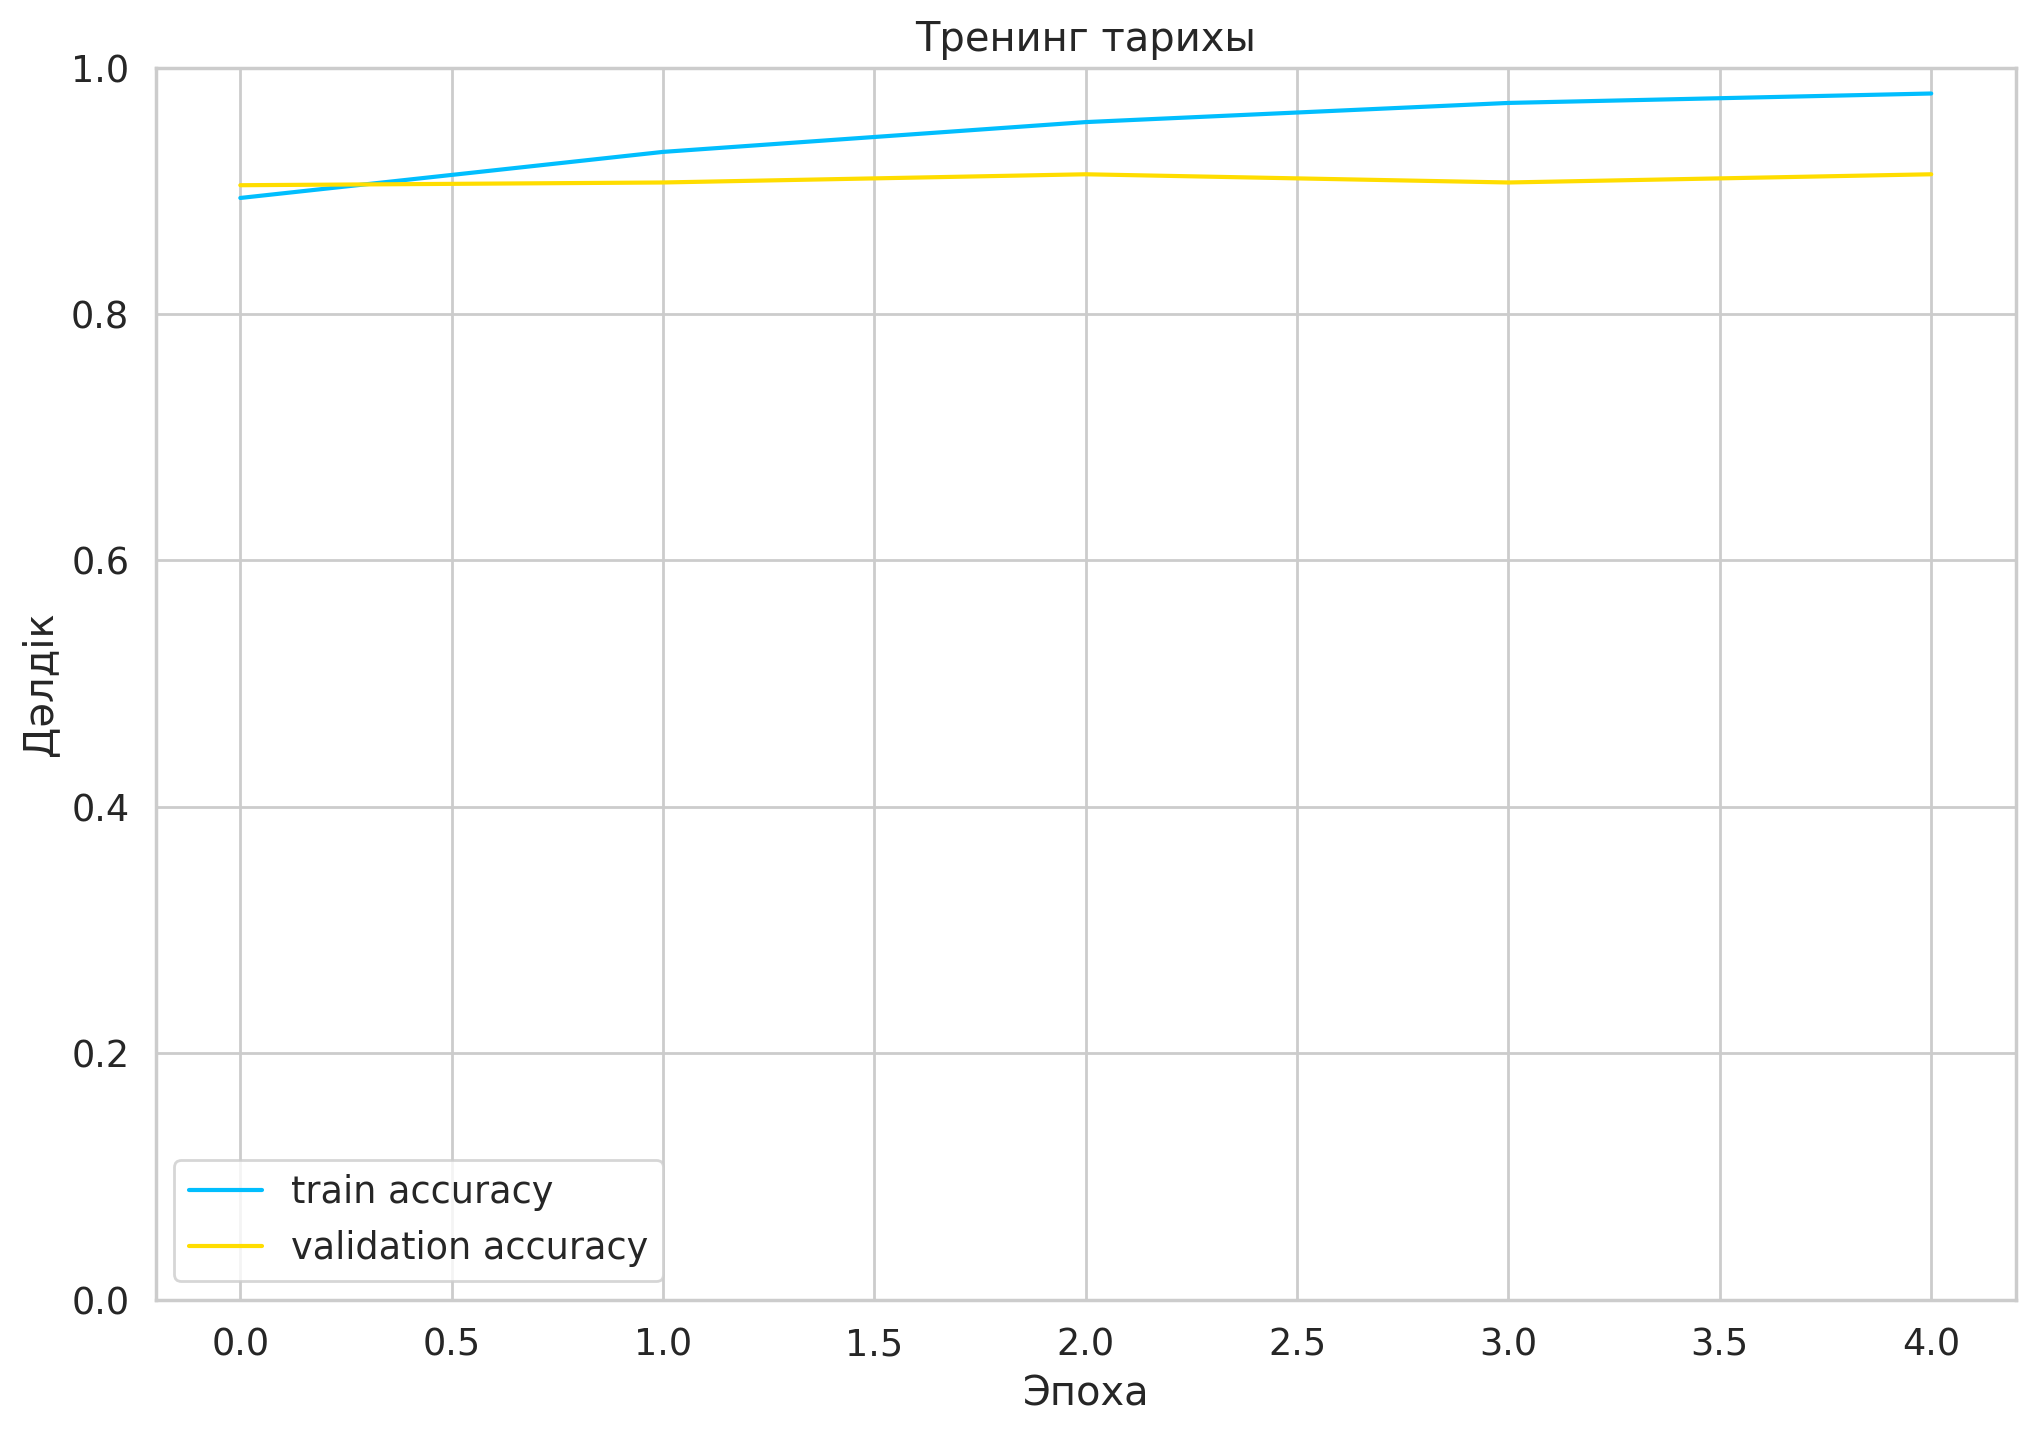

In [48]:
train_acc = [t.detach().cpu().numpy() for t in history['train_acc']]
val_acc   = [t.detach().cpu().numpy() for t in history['val_acc']]

plt.plot(train_acc, label='train accuracy')
plt.plot(val_acc,   label='validation accuracy')
plt.title('Тренинг тарихы')
plt.ylabel('Дәлдік')
plt.xlabel('Эпоха')
plt.legend()
plt.ylim([0, 1])
plt.show()


Жаттығу дәлдігі шамамен 5 Эпохадан кейін 98% жақындай бастайды. Параметрлерді біршама fine-tuning тырысуыңыз мүмкін, бірақ бұл біз үшін жеткілікті.

## Бағалау

Сонымен, біздің көңіл-күйді болжау үлгісі қаншалықты жақсы? Сынақ деректерінің дәлдігін есептеуден бастайық:

In [49]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.9002217294900222

Сынақ жиынында дәлдік шамамен 7% төмен. Біздің модель жақсы жалпыланған сияқты.

Модельден болжамдарды алу үшін көмекші функцияны анықтаймыз:

In [50]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

Бұл бағалау функциясына ұқсас, тек біз шолулар мәтінін және болжамды ықтималдықтарды сақтаймыз (модель нәтижелеріне softmax қолдану арқылы):

In [51]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Классификация есебін қарастырайық

In [52]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.76      0.69      0.72        54
     neutral       0.26      0.24      0.25        21
    positive       0.95      0.97      0.96       376

    accuracy                           0.90       451
   macro avg       0.66      0.63      0.64       451
weighted avg       0.90      0.90      0.90       451



Бейтарап (3 жұлдыз) пікірлерді жіктеу өте қиын сияқты. Көптеген шолуларға қарап, оларды жіктеу қиын.

Шатасу матрицасын жалғастырамыз:

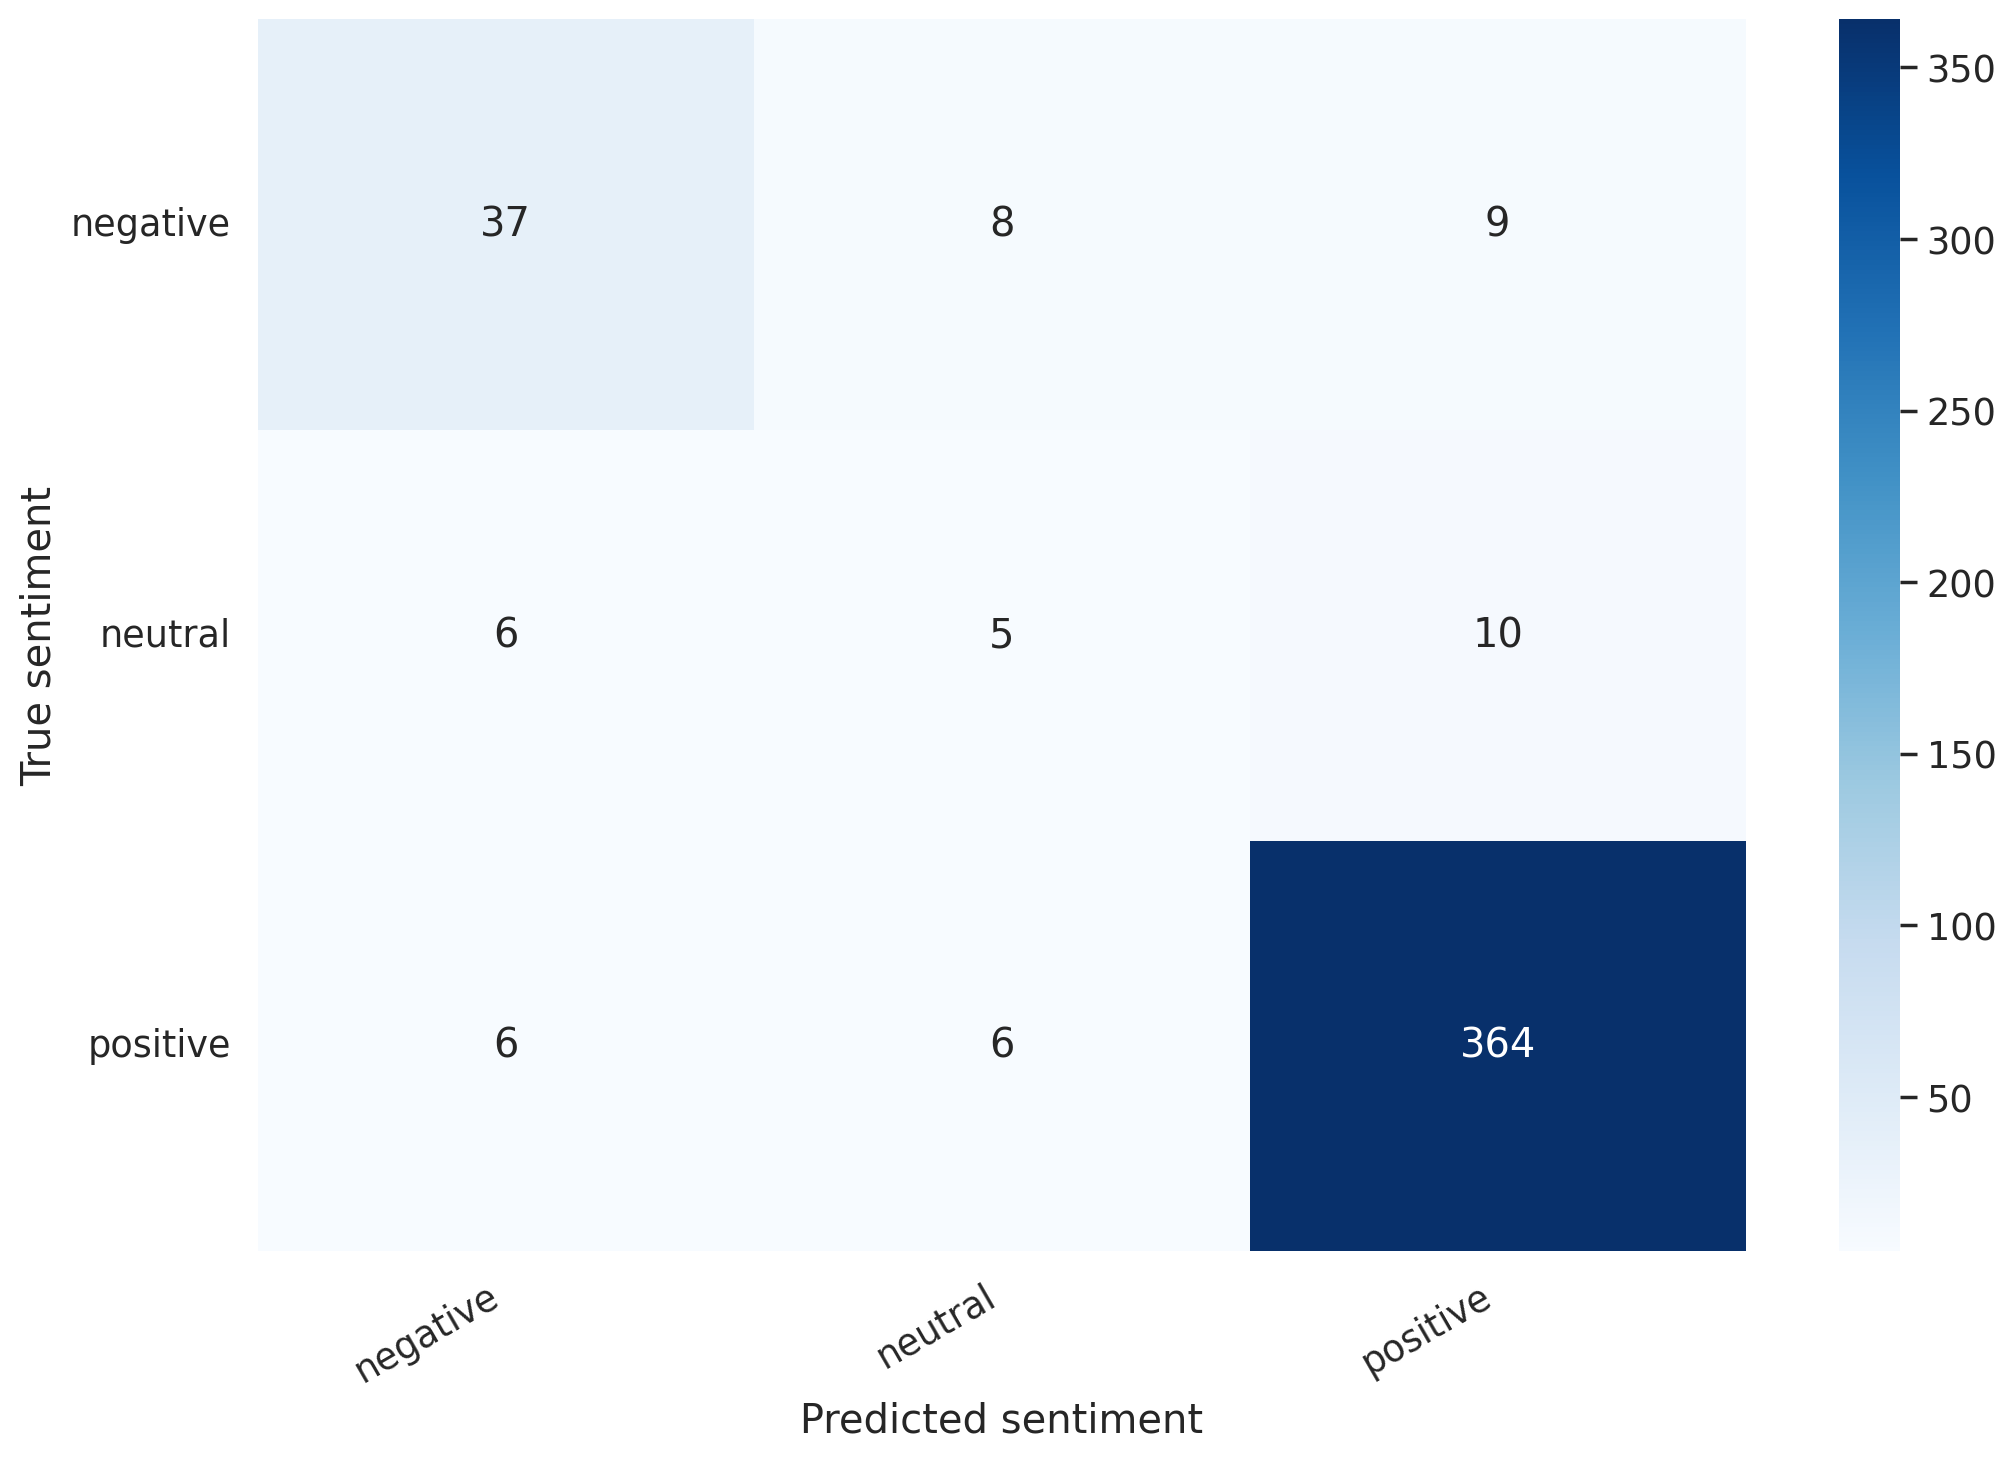

In [53]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

Бұл біздің үлгіміздің бейтарап шолуларды жіктеу қиынға соғып жатқанын растайды. Ол шамамен бірдей жиілікте теріс және оң деп қателеседі.

Бұл біздің модельдің өнімділігі туралы жақсы шолу. Бірақ сынақ деректерінен мысалды қарастырайық:Бұл біздің үлгіміздің бейтарап шолуларды жіктеу қиынға соғып жатқанын растайды. Ол шамамен бірдей жиілікте теріс және оң деп қателеседі.

Бұл біздің модельдің өнімділігі туралы жақсы шолу. Бірақ сынақ деректерінен мысалды қарастырайық:

In [54]:
idx = 3

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [55]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

Көптеген іздеген махер жамылғы флип.кз-тен табылды, бағасы, сапасы
жақсы. Жылы үйде ең қажетті жамылғы. Жағажайға да алып баруға болаы.
Алдымен күлгін түсіне тапсырыс бердім. Кейін мята түсіне де тапсырыс
бердім.

True sentiment: positive


Енді біз үлгідегі әрбір сезімнің сенімділігіне қарай аламыз:

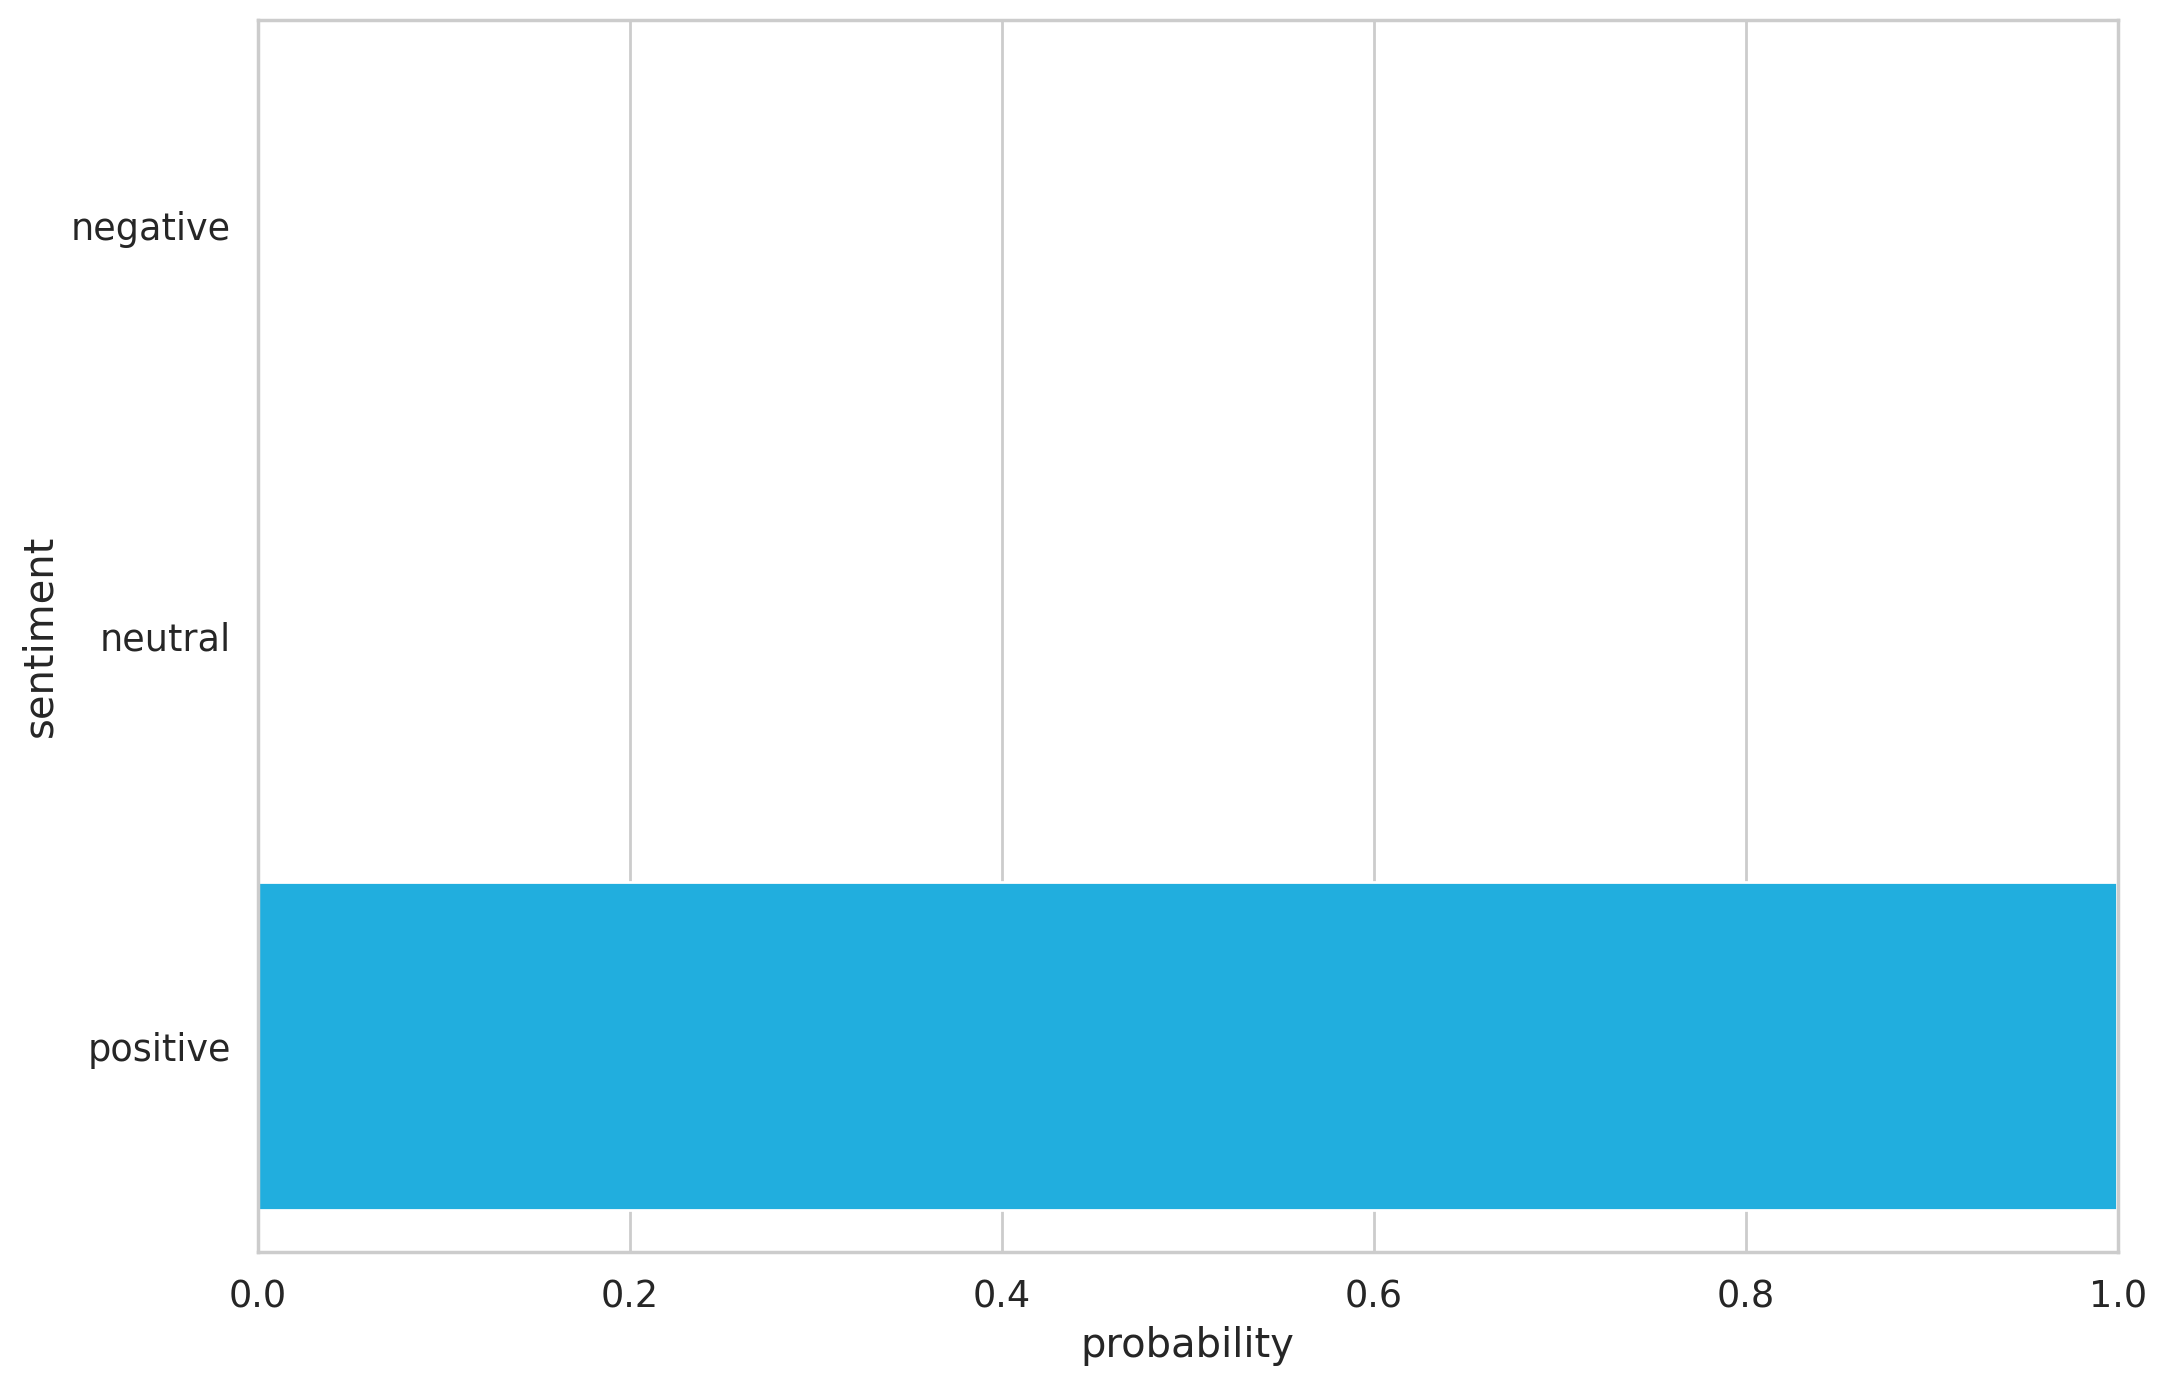

In [56]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

### Мәтінді болжау

Кейбір өңделмеген мәтіннің сезімін болжау үшін үлгімізді қолданайық:

In [57]:
review_text = "Мен тапсырмаларымды аяқтағанды ​​жақсы көремін! Ең жақсы қолданба!!!"

Мәтінді кодтау үшін токенизаторды пайдалануымыз керек:

In [58]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding='max_length',
  truncation=True,
  return_tensors='pt',
)

Біздің модельден болжамдарды алайық:

In [59]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Пікірлері: {review_text}')
print(f'Сезім    : {class_names[prediction]}')

Пікірлері: Мен тапсырмаларымды аяқтағанды ​​жақсы көремін! Ең жақсы қолданба!!!
Сезім    : positive


## Тапсырма

12‑аптада жинаған деректер жиыныңызды пайдаланып, барлық кодты қайтадан іске қосып шығыңыз және өзгерістер енгізу қажет жерлерге мұқият назар аударыңыз.